<header style="padding:1px;background:#f9f9f9;border-top:3px solid #00b2b1"><img id="Teradata-logo" src="https://www.teradata.com/Teradata/Images/Rebrand/Teradata_logo-two_color.png" alt="Teradata" width="220" align="right" />

<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Flexible, Scalable Storage and Analytics with Vantage</b>
</header>

<br>

<p style = 'font-size:16px;font-family:Arial'>Teradata's VantageCloud Lake Edition is the only enterprise-class analytics platform that enables powerful, open, and flexible analytics against data in any location; Data Lakes, third-party systems, and traditional EDW.</p>

<hr>

<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Environment Overview</b>

<p style = 'font-size:16px;font-family:Arial'>This demonstration will illustrate how users can can use Vantage to access data from a variety of external sources, choose from multiple physical and virtual storage tiers, and then derive valuable analytic and business insights at extreme scale with minimal cost.</p>

<p style = 'font-size:16px;font-family:Arial'>Data Architects and Engineers have a choice of a broad data locality and storage types that can help optimize the balance between cost, accessibility, and analytic performance.  These storage types include:</p>

<table style = 'width:100%;table-layout:fixed;'>
    <tr>
        <td style = 'vertical-align:top;font-size:16px;font-family:Arial' width = '50%'>
            <ol style = 'font-size:16px;font-family:Arial'>
                <li>Direct-attached block storage for high-speed, tactical workloads.  Most common for smaller, dimensional tables, or tables that support tactical, near-real-time query patterns.</li>
                <br>
                <li>An object-storage-based filesystem named the Vantage Object Filesystem (OFS) which features:
                    <ul style = 'font-size:16px;font-family:Arial'>
                        <li>Massively scalable low-cost storage</li>
                        <li>Data sharing across multiple processing clusters</li>
                <li>Full ACID compliance and optimized for performance including caching, optimized spool, indexed metadata</li>
                    </ul>
                </li>
                <br>
                <li>Open Object Storage; which can include Data Lakes (including formats such as Delta), IIOT data, Data Marketplaces, and many other third-party ETL and data streaming systems.</li>
            </ol>
        </td>
        <td><img src = 'images/Arch_Simple.png' width = '400'></td>
    </tr>
</table>

<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Demonstration Overview</b>

<p style = 'font-size:16px;font-family:Arial'>This notebook consists of three primary demonstrations designed to briefly review these storage types and how they can be mixed transparently for analytical processing.  </p>
<ol style = 'font-size:16px;font-family:Arial'>
    <li><b>Demo 1 - The Object Filesystem (OFS)</b>. Show how users can load data, execute queries, as well as how leverage Time Travel capabilities</li>
    <li><b>Demo 2 - Open Object Storage</b> - Data Discovery and analytics against data in S3, and an illustration of how to simplify access for users</li>
    <li><b>Demo 3 - Analytics</b> - Combine data across storage tiers and apply powerful, scalable ClearScape Analytics Functions</li>
    </ol>


<hr>

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'>Connect to Vantage</p>

<p style = 'font-size:16px;font-family:Arial'>This notebook uses the Vantage Plugin for Jupyter; a Jupyter Lab Extension that provides native SQL processing, administrative magic functions, and visualiztion capabilities.  In order to conntect to our Vantage system, the user needs to create a connection - this connection is stored in the user's profile and doesn't need to be recreated each time.</p> 

In [108]:
%addconnect name=lake_demo, host=18.220.148.208

ERROR: Connection with the name 'lake_user' already exists

In [1]:
%chconnect name=lake_demo, host=18.220.148.208

Success: 'lake_demo' connection modified


In [17]:
%disconnect lake_demo

ERROR: Profile lake_demo not connected

password is 'password':

In [2]:
%connect lake_demo, user=data_engineer, hidewarnings=True

Password: ········


Success: 'lake_demo' connection established and activated for user 'data_engineer'


In [3]:
--Set user's session to use the "Standard" Compute Group
SET SESSION COMPUTE GROUP CG_BUSGRPA_STD

Success: 1 rows affected

<hr>
<p style = 'font-size:28px;font-family:Arial;color:#E37C4D'><b>Demonstration 1 - Vantage Object FileSystem (OFS)</b></p>

<table style = 'width:100%;table-layout:fixed;'>
    <tr>
        <td style = 'vertical-align:top' width = '40%'>
            <ul style = 'font-size:16px;font-family:Arial'>
                <li>Immutable storage, objects are versioned to guarantee consistency</li>
                <br>
                <li>The Object File System (OFS) index is represented by a tree structure with a single root with multiple leaf nodes:
                    <br>
                    <ul><br>
                        <li>One internal index structure is created for each OFS table</li>
                    <br>
                        <li>Internal indexes provide efficiency in multiple ways:
                        <ul>
                            <li>Filtering out selected rows</li>
                            <li>Pre-positioning index entries across AMPs</li>
                            <li>Join column redistributions</li>
                            </ul></li>
                        <br>
                        <li>Set of statistics values for up to 64 columns carried in the root (for each leaf) and the leaf objects (for each data object)</li>
                <br>
                <li>Index row sizes can be up to 1 MB</li>
                    </ul></li>
            </ul>
        </td>
        <td><img src = 'images/OFS_Structure.png' width = '600'></td>
    </tr>
</table>

<hr>

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'>Create the OFS Table</p>

<p style = 'font-size:16px;font-family:Arial'>For purposes of demonstration, the user will DROP the table prior to loading so as to show how a new table can be created.</p> 

<p style = 'font-size:16px;font-family:Arial'>Tables can be defined as generally normally done with any RDBMS.  However, in this case we will show some specifics that are unique to Vantage.</p>
<ul style = 'font-size:16px;font-family:Arial'><li><b>First</b>, the "STORAGE" clause is set to indicate the data will be stored in the OFS framework.</li>
    <li><b>Second</b>, the SELECT that is used to populate the table consists of a specific query type designed to read data directly from an Object Store.</li> </ul>
    
<p style = 'font-size:16px;font-family:Arial'>Finally, the table can be queried as any normal relational table.</p>

In [20]:
DROP TABLE demo.Txn_History_OFS

ERROR: Unable to run SQL: Unable to run SQL query: Database reported error:3807:Object 'demo.Txn_History_OFS' does not exist.

In [4]:
/* Load the data into OFS directly from S3
*/

--EXPLAIN
CREATE TABLE demo.Txn_History_OFS,

    /*Note the use of STORAGE here to specify OFS
    This can also be set to a user and database default */
    
    STORAGE=TD_OFSSTORAGE
    
    /* We can use a SELECT statement to populate the table
    using WITH DATA */
    AS (

        /*Provide json path information to identify the proper fields */
        SELECT Payload.txn_id txn_id,
            Payload.step step,
            Payload."type" "txn_type",
            CAST(Payload.amount AS FLOAT) amount,
            Payload.nameOrig nameOrig,
            CAST(Payload.oldbalanceOrig AS FLOAT) oldbalanceOrig,
            CAST(Payload.newbalanceOrig AS FLOAT) newbalanceOrig,
            Payload.nameDest nameDest,
            CAST(Payload.oldbalanceDest AS FLOAT) oldbalanceDest,
            CAST(Payload.newbalanceDest AS FLOAT) newbalanceDest,
            CAST(Payload.isFraud AS INTEGER) isFraud,
            CAST(Payload.isFlaggedFraud AS INTEGER) isFlaggedFraud

        FROM (
            LOCATION = '/s3/s3.amazonaws.com/trial-datasets/FraudReduction/'
            AUTHORIZATION = Repositories.PubAuth
) AS D
) WITH DATA;

Success: 0 rows affected

In [5]:
/* Run a basic query against the data 
Note we can use AS OF syntax to select a specific version
Visualize results */

SELECT txn_type, COUNT(isFraud), SUM(isFraud) fraud_txns
FROM demo.Txn_History_OFS 

GROUP BY 1;

,txn_type,isFraud,fraud_txns
1,CASH_OUT,20958,36
2,CASH_IN,13142,0
3,DEBIT,387,0
4,TRANSFER,5045,40
5,PAYMENT,20468,0


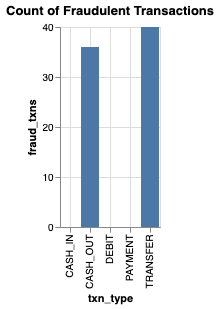

In [6]:
%chart x=txn_type, y=fraud_txns, title="Count of Fraudulent Transactions"

<hr>
<p style = 'font-size:28px;font-family:Arial;color:#E37C4D'><b>Time Travel with OFS</b></p>

<table style = 'width:100%;table-layout:fixed;'>
    <tr>
        <td style = 'vertical-align:top' width = '40%'>
            <ul style = 'font-size:16px;font-family:Arial'><b>Benefits of Time Travel</b>
                <br>
                <br>
                <li>Querying the database based on how the data looked at some point in the past</li>
                <br>
                <li>If there were problems with a data load, users can go back to a point in time where the data is clean/consistent</li>
                 <br>
                 <li>Analytics can be re-run it keeping the inputs the same for one or more tables at any point in time</li>
                <br>
            </ul>
            <ul style = 'font-size:16px;font-family:Arial'><b>Features</b>
                <br>
                <br>
                <li>supported through SELECT AS OF syntax</li>
                <br>
                <li>Versions come with a system default retention period</li>
                <br>
                <li>Versioning allows readers to not be blocked by writers, and vice versa</li>
                <br>
                <li>A transactionally consistent read is always provided by using the last committed version</li>
            </ul>               
                </td>
        <td><img src = 'images/Time_Travel.png' width = '400'></td>
    </tr>
</table>

<hr>

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'>Time Travel Demonstration</p>

<p style = 'font-size:16px;font-family:Arial'>As discussed above, OFS tables have a defined retention period over which versions are stored.  This can be viewed by executing a SHOW STORAGE ACCESS statement to see the internal bucket information, including retention period.</p> 

<p style = 'font-size:16px;font-family:Arial'>Next, some additional data will be inserted into the table.  Executing a query gainst the VersionInfo view can show the version history</p>
    
<p style = 'font-size:16px;font-family:Arial'>Finally, the table can be queried using AS OF syntax to illustrate simple row counts before and after changes</p>

In [7]:
--Show the internal S3 bucket and retention (time travel) policy
SHOW STORAGE ACCESS TD_OFSSTORAGE

,Request Text
1,"CREATE STORAGE ACCESS OFS TD_OFSSTORAGE , AUTHORIZATION TD_OFSDB.OFSAUTH USING ( LOCATION ('/s3/s3.amazonaws.com/pod-tenant-tc3330d1-acc-3330d14d5a-nosfs/') MANAGED ('true') RETENTIONDAYS ('30') );"


In [8]:
/* Insert some additional rows into our OFS Table */
INSERT INTO demo.Txn_History_OFS

        /*Provide json path information to identify the proper fields */
        SELECT TOP 10000 Payload.txn_id txn_id,
            Payload.step step,
            Payload."type" "txn_type",
            CAST(Payload.amount AS FLOAT) amount,
            Payload.nameOrig nameOrig,
            CAST(Payload.oldbalanceOrig AS FLOAT) oldbalanceOrig,
            CAST(Payload.newbalanceOrig AS FLOAT) newbalanceOrig,
            Payload.nameDest nameDest,
            CAST(Payload.oldbalanceDest AS FLOAT) oldbalanceDest,
            CAST(Payload.newbalanceDest AS FLOAT) newbalanceDest,
            CAST(Payload.isFraud AS INTEGER) isFraud,
            CAST(Payload.isFlaggedFraud AS INTEGER) isFlaggedFraud

        FROM (
            LOCATION = '/s3/s3.amazonaws.com/trial-datasets/FraudReduction/'
            AUTHORIZATION = Repositories.PubAuth
) D

Success: 10000 rows affected

In [9]:
-- Show Table Versioning for Time Travel capabilities
SELECT TableName, OFSStartVersionNumber, VersionTimeStamp FROM DBC.MultiVersionInfoTblV
WHERE DatabaseName = 'demo'
AND TableName = 'Txn_History_OFS'
ORDER BY 2;

,TableName,OFSStartVersionNumber,VersionTimeStamp
1,Txn_History_OFS,0,2023-09-06 14:53:45.950000+00:00
2,Txn_History_OFS,1,2023-09-06 14:54:12.180000+00:00


In [10]:
/* Count the number of rows after each version
Replace the timestamps as necessary 
Or use the version number */

SELECT 'Original' as Ver, COUNT(*) 
FROM demo.Txn_History_OFS 
    --AS OF TIMESTAMP '2023-02-13 11:19:28.360000-04:00'
    AS OF 0

GROUP BY 1

UNION ALL 

SELECT 'New Ver' as Ver, COUNT(*) 
FROM demo.Txn_History_OFS 
    --AS OF TIMESTAMP '2023-02-13 15:20:04.580000-04:00'
    AS OF 1

GROUP BY 1

,Ver,Count(*)
1,Original,60000
2,New Ver,70000


<hr>
<p style = 'font-size:28px;font-family:Arial;color:#E37C4D'><b>Demonstration 2 - Data in External Object Stores</b></p>

<table style = 'width:100%;table-layout:fixed;'>
    <tr>
        <td style = 'vertical-align:top' width = '40%'>
            <ul style = 'font-size:16px;font-family:Arial'>
                <li>Vast quantities of data stored in Object Storage
                    <br>
                <ul>
                    <br>
                    <li>Data Lakes</li>
                    <br>
                    <li>IOT/IIOT</li>
                    <br>
                    <li>Marketplaces</li><br>
                    </ul></li>
                <br>
                <li>Vantage can read this data directly using built-in capabilities:
                    <br>
                    <ul><br>
                        <li>At massive scale/parallelism</li>
                    <br>
                        <li>Automatic schema discovery</li>
                        <br>
                            <li>Read optimizations/object filtering</li>
                            </ul></li>
                <br>
                <li>Administrators can create objects to enable easy access/analysis:
                <ul><br>
                    <li>Foreign Tables that contain object locations and definitions</li>
                    <br>
                    <li>Views to simplify access for users</li>
                    </ul>
                </li>
            </ul>
        </td>
        <td><img src = 'images/Data_Marketplace.png' width = '600'></td>
    </tr>
</table>

<hr>

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'>Exploration and Access Data in Object Stores</p>

<p style = 'font-size:16px;font-family:Arial'>The illustrations below review some common query types for investigating data in object storage.  Adding a "RETURNTYPE" parameter to the query can return additional information about the data:</p>
<ul style = 'font-size:16px;font-family:Arial'>
    <li><b>NOSREAD_KEYS</b> will return objects keys/key paths, length in bytes, etc.</li>
    <li><b>NOSREAD_SCHEMA</b> will return the objects schema as interpreted by Vantage</li>
    </ul>

<p style = 'font-size:16px;font-family:Arial'>The Data Engineer can then create a <b>Foreign Table</b> which acts as a virtual pointer to the data as it lies in Object Storage.  Optionally, this table can contain filtering mechanisms to assist in minimizing download volumes and improving performance.</p>

In [11]:
/* Investigate object structure */

SELECT Location, ObjectLength

FROM (
    LOCATION = '/s3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/'
    AUTHORIZATION = retail_sample_data.DEMO_AUTH_NOS
    RETURNTYPE = 'NOSREAD_KEYS'
) AS D

,Location,ObjectLength
1,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_1.csv,14680002
2,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_10.csv,9949618
3,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_2.csv,14679966
4,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_3.csv,14680146
5,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_4.csv,14680017
6,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_5.csv,14680095
7,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_6.csv,14680063
8,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_7.csv,14679943
9,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_8.csv,14680277
10,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_9.csv,14679948


In [12]:
/* Investigate object schema */

SELECT TOP 12 *

FROM (
    LOCATION = '/s3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/'
    AUTHORIZATION = retail_sample_data.DEMO_AUTH_NOS
    RETURNTYPE = 'NOSREAD_SCHEMA'
) AS D
ORDER BY 1

,ColPosition,Name,Datatype,FileType,Location
1,1,Col1,int,csv,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_1.csv
2,2,Col2,char(27) CHARACTER SET LATIN,csv,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_1.csv
3,3,Col3,VARCHAR(51) CHARACTER SET LATIN,csv,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_1.csv
4,4,Col4,char(3) CHARACTER SET LATIN,csv,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_1.csv
5,5,Col5,int,csv,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_1.csv
6,6,Col6,varchar(40) CHARACTER SET LATIN,csv,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_1.csv
7,7,Col7,smallint,csv,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_1.csv
8,8,Col8,int,csv,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_1.csv
9,9,Col9,char(34) CHARACTER SET LATIN,csv,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_1.csv
10,10,Col10,varchar(27) CHARACTER SET LATIN,csv,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_1.csv


In [9]:
DROP TABLE demo.Banking_History_S3

Success: 36 rows affected

In [13]:
/* Create the Foreign Table */

CREATE FOREIGN TABLE demo.Banking_History_S3,
    EXTERNAL SECURITY retail_sample_data.DEMO_AUTH_NOS
    (
    customer_skey                 integer,
    customer_identifier           varchar(26),
    customer_cookie               varchar(50),
    customer_online_id            varchar(3),
    customer_offline_id           integer,
    customer_type                 varchar(90),
    customer_days_active          integer,
    interaction_session_number      bigint,
    interaction_timestamp         timestamp with time zone,
    interaction_source            varchar(100),
    interaction_type              varchar(100),
    sales_channel            varchar(100))
USING
(
     LOCATION  ('/s3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/')
     MANIFEST  ('FALSE')
     ROWFORMAT  ('{"field_delimiter":",","record_delimiter":"\n","character_set":"LATIN"}')
     STOREDAS  ('TEXTFILE')
     HEADER  ('FALSE')
     STRIP_EXTERIOR_SPACES  ('FALSE')
     STRIP_ENCLOSING_CHAR  ('"')
)
NO PRIMARY INDEX ;

Success: 0 rows affected

In [14]:
SELECT TOP 10 * FROM demo.Banking_History_S3

,Location,customer_skey,customer_identifier,customer_cookie,customer_online_id,customer_offline_id,customer_type,customer_days_active,interaction_session_number,interaction_timestamp,interaction_source,interaction_type,sales_channel
1,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_1.csv,112110,125381050fjzrpwt771657752,EY4pH14_ZlZaQQKZpXdXRqo,N,-1,Visitor - Browse Only,0,4308895,2016-02-11 12:38:03.000000-07:00,WEBSITE,BROWSE,-1
2,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_8.csv,77310,305591565fsocziw320918796,ztmThhB1F4yVJz3pTXyzbvY,N,-1,Visitor - Browse Only,0,5093790,2016-01-12 11:30:04.000000-07:00,ONSITE_AD,CLICK,-1
3,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_9.csv,238628,723942387blqopyz768264691,mRejQzem5LYwyfL12shm68f-1,Y,545408141,Gold,94,1789480,2016-02-16 13:28:21.000000-07:00,WEBSITE,COMPARE,-1
4,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_4.csv,237278,566319047mpylzme563266592,B7BvWDimJKoTqB_sbsWH6KF,Y,560261797,Gold,1,3267787,2016-02-21 15:00:24.000000-07:00,WEBSITE,STARTS_APPLICATION,-1
5,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_6.csv,155870,994625921asfjncl350510568,UbsHsl36rFIqZdJrDd9Ya-Q,N,-1,Visitor - Browse Only,0,2832095,2016-03-24 18:54:44.000000-07:00,WEBSITE,BROWSE,-1
6,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_5.csv,2135,861839811lbxepnv901946824,55jkmJvnwpUIMI-zDGvsSra,N,560839436,Gold,1,4873958,2016-03-14 07:33:14.000000-07:00,WEBSITE,COMPARE,-1
7,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_7.csv,241125,881215615vjzlqop829238201,OM-7DENTnCcPO0r109jd8eL,Y,538408614,Platinum,798,3719924,2016-01-07 18:00:27.000000-07:00,WEBSITE,BROWSE,-1
8,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_3.csv,223375,832161474ylmoyeq507735216,Lhi-WtRHOzvlgmqs9fcUuPz,Y,-1,Visitor - Loyalty,0,4099749,2016-01-08 18:50:31.000000-07:00,WEBSITE,OLB,-1
9,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_2.csv,239956,831898057xcrapzz439247508,MWbJSSxkLUqB6VKnQC5RZr4,Y,404465918,Gold,1054,1884564,2016-02-03 16:54:07.000000-07:00,SOR_SALES_FILE,ACCOUNT_BOOKED_OFFLINE,BRANCH
10,/S3/s3.amazonaws.com/td-usecases-data-store/retail_sample_data/FSCustomerJourney/ich_banking/ich_banking_10.csv,123501,729007171htkuxfk312736187,JTHwxvgAmeoXycdIJUc6Ynl,N,-1,Visitor - Browse Only,0,5508838,2016-02-29 18:43:33.000000-07:00,WEBSITE,BROWSE,-1


In [15]:
SELECT COUNT(*) FROM demo.Banking_History_S3

,Count(*)
1,628723


<hr>
<p style = 'font-size:28px;font-family:Arial;color:#E37C4D'><b>Demonstration 3 - Join data across storage types</b></p>

<table style = 'width:100%;table-layout:fixed;font-size:16px;font-family:Arial'>
    <tr style = 'text-align:center'>
        <td><b>Customers_BFS, Accounts_Mapping_BFS</b>
        <br>Two dimension tables, stored in local BFS Storage on the Primary Cluster.</td>
                <td><b>Txn_History_OFS</b>
            <br>A large fact table with financial transaction detail information.  Data is stored in the Vantage Object Filesystem.</td>      
        <td><b>Banking_History_S3</b>
            <br>An extremely large external table containing Banking History. Data is stored as-is in S3.</td>
    </tr>
    </table>
    <table style = 'width:100%;table-layout:fixed;font-size:16px;font-family:Arial'>
    <tr>
        <td><img src = 'images/EBS_Tables.png'></td>
        <td><img src = 'images/OFS_Tables.png'></td>
        <td><img src = 'images/S3_Tables.png'></td>
    </tr>
</table>

In [16]:
/* Find banking users who have had a fradulent event in their cashapp account*/

SELECT TOP 10

txn.amount,
c.firstname,
c.lastname


FROM demo.txn_history_ofs txn, demo.Customers_BFS c, demo.Accounts_Mapping_BFS am


WHERE txn.isFraud = 1 AND
    txn.nameOrig= am.nameOrig AND
    am.customer_identifier = c.customer_identifier 

GROUP BY 1,2,3

,amount,firstname,lastname
1,2.29933046e+06,Jacob,Wilkins
2,2.08105156e+06,Danielle,Ahmed
3,829012.31,Benjamin,Godfrey
4,5.09694674e+06,Edward,Weston
5,127564.33,Phoebe,Jenkins
6,412668.39,Isabella,Pope
7,1.18672539e+06,Caitlin,Gordon
8,145035.4,Grace,Forster
9,1e+07,Amelie,Wong
10,432958.83,Megan,Briggs


<hr>

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'>Bringing it all together with ClearScape Analytics Functions</p>

<p style = 'font-size:16px;font-family:Arial'>This query will add two new elements to the analysis; adding in the large fact table stored natively in S3, and wrapping everything in a multi-row pattern analysis function named nPath. The goal of this analysis is identifying offline behavioral patterns leading to "Fraud" - a potentially valuable analysis that can directly feed more accurate Fraud prediction or early identification.</p>


<table style = 'width:100%;table-layout:fixed;font-size:16px;font-family:Arial'>
    <tr style = 'text-align:top'>
        <td style = 'width:30%'>
        <ol>
            <br>
            <li>Use the Join conditions above to identify Fraud in mobile app</li>
            <br>
            <li>Join the fradulent users to their offline identities</li>
            <br>
            <li>Pass this data to Teradata nPath function to idenfify offline bevaviors</li>
            <br>
        </ol></td>
        <td><img src = 'images/Life_Of_Query.png'></td>
    </tr>
</table>

In [17]:
/* Investigate user banking activities that preceeded a fraudulent online transaction */

SELECT * FROM NPATH
    (ON (
        SELECT
                bh.customer_identifier,
                bh.interaction_session_number,
                bh.interaction_timestamp,
                bh.interaction_type,
                txn.amount,
                c.firstname,
                c.lastname


                FROM demo.txn_history_ofs txn, demo.Banking_History_S3 bh, 
                    demo.Customers_BFS c, demo.Accounts_Mapping_BFS am


                WHERE txn.isFraud = 1 AND
                    txn.nameOrig= am.nameOrig AND
                    am.customer_identifier = bh.customer_identifier AND
                    am.customer_identifier = c.customer_identifier
        )
        
        PARTITION BY interaction_session_number
        ORDER BY interaction_timestamp
    USING
        MODE (NONOVERLAPPING)
        SYMBOLS (TRUE AS A)
        PATTERN ('A*')
        RESULT (FIRST (interaction_timestamp of A) as start_time, 
                FIRST (customer_identifier of A) as customer_identifier,
                FIRST (firstname of A) as firstname, 
                FIRST (lastname of A) as lastname,
                FIRST (amount of A) as fraud_amount,
                ACCUMULATE (interaction_type of ANY(A)) as path,
                FIRST (interaction_session_number of A) as interaction_session_number
                
    ));

start_time customer_identifier firstname lastname fraud_amount path interaction_session_number 1 2016-02-16 16:22:58.000000-07:00 382199496nujsfqt379492272 Caitlin Gordon 1.18672539e+06 [BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE] 7280496 2 2016-02-22 16:30:38.000000-07:00 228714836dfdzuow919946555 Phoebe Jenkins 127564.33 [COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE] 3688318 3 2016-02-13 11:39:23.000000-07:00 550877512qiultoa660406456 Amelie Wong 1e+07 [BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION] 5335956 4 2016-03-06 16:32:33.000000-07:00 315616825hhozhjg829286508 Benjamin Godfrey 829012.31 [BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, COMPLETE_APPLICATION, COMPLETE_APPLICATION, COMPLETE_APPLICATION, COMPLETE_APPLICATION, COMPLETE_APPLICATION, COMPLETE_APPLICATION, COMPLETE_APPLICATION, COMPLETE_APPLICATION, COMPLETE_APPLICATION, COMPLETE_APPLICATION, COMPLETE_APPLICATION, COMPLETE_APPLICATION, ACCOUNT_BOOKED_ONLINE, ACCOUNT_BOOKED_ONLINE, ACCOUNT_BOOKED_ONLINE, ACCOUNT_BOOKED_ONLINE, ACCOUNT_BOOKED_ONLINE, ACCOUNT_BOOKED_ONLINE, ACCOUNT_BOOKED_ONLINE, ACCOUNT_BOOKED_ONLINE, ACCOUNT_BOOKED_ONLINE, ACCOUNT_BOOKED_ONLINE, ACCOUNT_BOOKED_ONLINE, ACCOUNT_BOOKED_ONLINE, COMPLETE_APPLICATION, COMPLETE_APPLICATION, COMPLETE_APPLICATION, COMPLETE_APPLICATION, COMPLETE_APPLICATION, COMPLETE_APPLICATION, COMPLETE_APPLICATION, COMPLETE_APPLICATION, COMPLETE_APPLICATION, COMPLETE_APPLICATION, COMPLETE_APPLICATION, COMPLETE_APPLICATION] 2245141 5 2016-03-13 03:41:47.000000-07:00 990829121nztvwns574946555 Isabella Pope 412668.39 [COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, COMPARE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION] 4553859 6 2016-02-23 13:53:20.000000-07:00 723346324bqtywyv557899717 Jacob Wilkins 2.29933046e+06 [STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE] 3239057 7 2016-02-21 18:24:51.000000-07:00 228714836dfdzuow919946555 Phoebe Jenkins 127564.33 [BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, BROWSE, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, STARTS_APPLICATION, S

In [35]:
%disconnect lake_demo

Success: 'lake_demo' disconnected